# San Francisco Crime Analysis from Summer 2014 Data

In [127]:
%matplotlib inline
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import re
import matplotlib
from mpl_toolkits.basemap import Basemap
from statsmodels.graphics.mosaicplot import mosaic

matplotlib.style.use('ggplot')

## Basic Analysis From Data
### Most Frequent Type of Crime
#### This data is from June-August 2014 summer months for the year 2014. From a casual look at data we can see that there crimes are divided into several "types", the first question I wanted to answer was what is the most common crime in this period. The plot below shows that "Larceny/Theft" stands out as significantly higher than the next closest crime type.

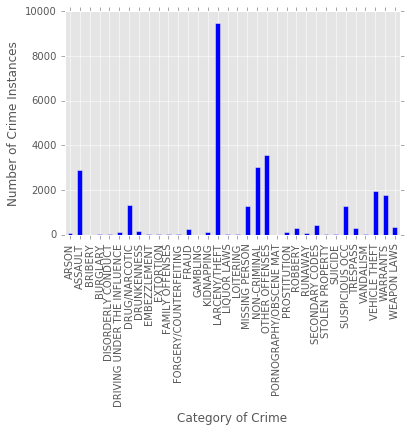

In [145]:
df = pd.read_csv("sanfrancisco_incidents_summer_2014.csv")
fig = df.groupby('Category').size().plot(kind='bar');
fig.set_ylabel("Number of Crime Instances");
fig.set_xlabel("Category of Crime");

### Crime Division by San Francisco Neighborhoods
#### Crime in United States is very neighborhood centric, to check how the number of criminal instances vary based on the San Francisco Neighborhoods tracked in the data a plot is generated below. Data shows that there is a clear area with significantly more crime instances ("Southern") than others. Richmond and Park neighborhoods have the least instances of recorded criminal activity.

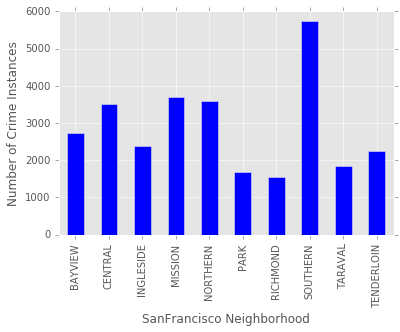

In [146]:
fig = df.groupby('PdDistrict').size().plot(kind='bar');
fig.set_ylabel("Number of Crime Instances");
fig.set_xlabel("San Francisco Neighborhood");

### Crime by Day Of the Week
#### Another view into the data can be to see correlation between a day of week and time of day with number of crimes. First a look at how the crime data varies depending on the day of the week below shows that there is no strong correlation between crime and day of the week.

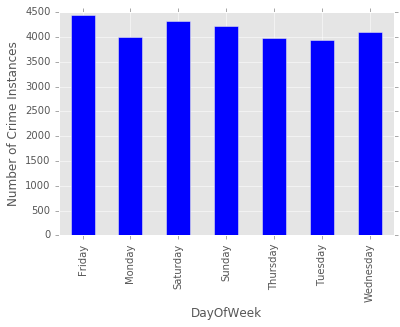

In [147]:
fig = df.groupby('DayOfWeek').size().plot(kind='bar');
fig.set_ylabel("Number of Crime Instances");

### Crime Heat Map
#### To get a more direct feel for the distribution of the relative crime frequency a heat map like the one generated below shows the distribution of crime. Aqua color is the bay and ocean and San Francisco is shown by coral color. The crime heat map is shown in blue dots, blue dots are generated from the Location data attached with each crime report. Couple of points are lying in the ocean and it is not clear if this is real data or corrupted data entries for crime location.

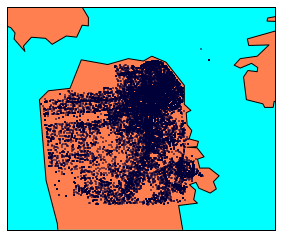

In [153]:
map = Basemap(projection='merc',lat_0="37.75",lon_0="-122.4",
              llcrnrlon=-122.544029, llcrnrlat=37.690470,
              urcrnrlon=-122.306451, urcrnrlat=37.846792,
              resolution = 'h')

def get_lat(row):
    b = re.split("[,)( ]", row.Location)
    return b[1]

def get_lon(row):
    b = re.split("[,)( ]", row.Location)
    return b[3]

df.lat = df.apply(lambda row: get_lat(row), axis=1)
df.lon = df.apply(lambda row: get_lon(row), axis=1)

arr1 = np.array(df.lon.astype(float))
arr2 = np.array(df.lat.astype(float))

x, y = map(arr1, arr2)

map.drawcoastlines();
map.fillcontinents(color = 'coral');
map.drawmapboundary(fill_color='aqua');

map.plot(x, y,'bo',markersize=1);

## Deeper Look into Data
### Temporal Crime Characteristics
#### Crime report times are broken into buckets of 1 hour ranging from midnight at '0' to hour 23 reflecting '11' pm. Very clear indication that net crime drops after midnight and then is lowest in early dawn hours before rising steeply in morning hours to a steady high value late in the evening. Crime is at it's peak in the evening hours from 4 - 6 pm before falling gradually till midnight.

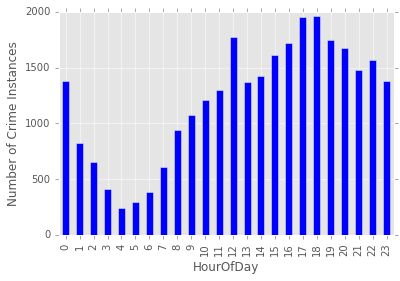

In [154]:
def get_hour(row):
    return int(row['Time'].split(":")[0])

df['HourOfDay'] = df.apply(lambda row: get_hour(row), axis=1)
fig = df.groupby('HourOfDay').size().plot(kind='bar');
fig.set_ylabel("Number of Crime Instances");

### Day of Week Temporal Crime Division
#### It is interesting to see that the relative crime patters remains very similar across all days of the week. The plot below summarizes the 24 hours of each week day. The relative width of the seven colums of different colors is very similar which points to the fact noted earlier that day of the week does not have major difference in the amout of crime. But even more importantly each column shows that the thin band (which show less crime frequency) are in the early morning hours for each day of the week and the thick bands are in the afternoon hours. Each color represents a different day of the week and the difference in the hue of the color for each column represents the variance of the crime in that block, as the hue does not change much for any day except Sunday after midnight it is rather surprising that the patter of crime on any day of the week at any given hour (except maybe Sunday after midnight) is very predictable. If this pattern hold on larger datasets too (this data set if for 3 summer months), then it can help in accounting how to use law enforcement resources too in a predictable manner.

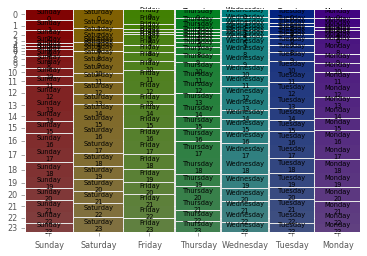

In [156]:
plt.rcParams['font.size'] = 8.0

mosaic(df, ['DayOfWeek', 'HourOfDay']);

## Day of Week Temporal Crime (6 hour day intervals)
#### Matrix above is little cluttered, a similar view in the data below by using each day divided into 4 intervals instead of 24 intervals. The pattern again shows that the time from midnight to noon is significantly safer than the other half of the day irrespective of which day of the week it is.

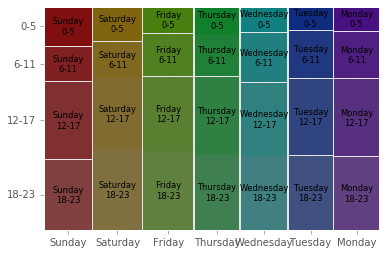

In [132]:
qtr_hr = {0: '0-5', 1:'6-11',2:'12-17',3:'18-23'}
def get_quarter_hour(row):
    hr = int(row['Time'].split(":")[0])
    return qtr_hr[hr / 6]

df['QtrHr'] = df.apply(lambda row: get_quarter_hour(row), axis=1)
mosaic(df, ['DayOfWeek', 'QtrHr']);

## Day of Week Temporal Crime with Crime Type
#### Finally the plot below looks at the most frequent types of crimes and shows how they are distributed for a given day of the week and for a given time during the day. Time is again divided into 4 quarters for a day. Interesting to observe that the type of crime very closely follows the net pattern of the overall criminal activity. The width of columns shows the relative amounts of different crime types with Larceny/Theft showing the most amount (color red below). In general there is little bit of variance in the amount of crime in early morning hours after midnight but later in the day the crime pattern is very predictable (shown by less saturated hues). Bands for crimes for the hours from midnight to noon (0-5, and 6-noon) are much less than rest of the other half of the day as shown in broader crime pattern.

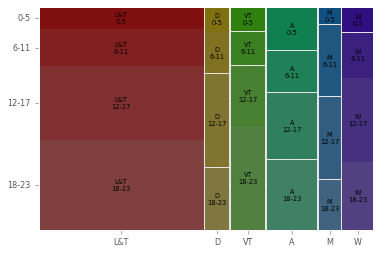

In [75]:
important_category = {'LARCENY/THEFT':'L&T', 'VEHICLE THEFT':'VT', 
                      'WARRANTS':'W', 'MISSING PERSON':'M', 'ASSAULT':'A',
                      'DRUG/NARCOTIC': 'D'}

def get_imp_category(row):
    if row['Category'] in important_category.keys():
        return important_category[row['Category']]
    else:
        return 'O'

df2 = df [ df.Category.isin( ['LARCENY/THEFT', 'VEHICLE THEFT','WARRANTS',
                              'MISSING PERSON','ASSAULT','DRUG/NARCOTIC'] ) ].copy()

df2['ImpCategory'] = df2.apply(lambda row: get_imp_category(row), axis=1)    
    
mosaic(df2, ['ImpCategory', 'QtrHr']);
df2 = None

## Conclusion
#### We see that the crime is very predictable not only in the type but also in the temporal and weekly distribution. These characteristics should be valuable in determining the amount and temporal utilization of law enforcement resource type which should be needed to counter these incidents.